In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
!pip install torchtext
import torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
uploaded = files.upload()
# here upload the zipped dataset folder (i.e. data.zip)

In [42]:
!unzip data.zip

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [43]:
import os

# Define the path to the directory containing the .txt files
directory_path = r'/content/data/names'

# Initialize an empty list to store the data
data = []

# Loop through each file in the directory
for filename in os.listdir(directory_path):
    # Get the language name from the file name (assuming file names are in the format "language.txt")
    language = os.path.splitext(filename)[0]
    # Open the file and read in each name, stripping any whitespace or newline characters
    with open(os.path.join(directory_path, filename), "r") as f:
        for line in f:
            # Append each name along with its language to the list
            data.append((line.strip(), language))

# Convert the list to a pandas DataFrame
df = pd.DataFrame(data, columns=['name', 'language'])

# Shuffle the DataFrame randomly
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the DataFrame into train, validation, and test sets with an 80:10:10 split
train, val, test = np.split(df, [int(0.8*len(df)), int(0.9*len(df))])

# Print the number of examples in each set
print("Number of examples in train set:", len(train))
print("Number of examples in validation set:", len(val))
print("Number of examples in test set:", len(test))


Number of examples in train set: 16059
Number of examples in validation set: 2007
Number of examples in test set: 2008


In [44]:
# Define the maximum length of the input sequence
MAX_SEQUENCE_LENGTH = 20

# Define the batch size and number of epochs
BATCH_SIZE = 64
NUM_EPOCHS = 20

# Preprocessing and split the data into train, val, and test (80:10:10)

In [45]:
import torchtext.vocab as vocab

# Create a tokenizer function to split the text data into tokens
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

# Get the text data from the training set
train_texts = train['name'].tolist()

# Create a vocabulary from the training data
vocab_data = [tokenizer(text) for text in train_texts]
vocab = vocab.build_vocab_from_iterator(vocab_data, specials=["<unk>"])

# Convert the text data to integer sequences using the vocabulary
train_sequences = [torch.tensor([vocab[token] for token in tokenizer(text)], dtype=torch.long) for text in train_texts]

# For the validation and test sets, replace out-of-vocabulary words with <unk>
val_texts = [text if all(token in vocab for token in tokenizer(text)) else "<unk>" for text in val['name'].tolist()]
test_texts = [text if all(token in vocab for token in tokenizer(text)) else "<unk>" for text in test['name'].tolist()]

val_sequences = [torch.tensor([vocab[token] for token in tokenizer(text)], dtype=torch.long) for text in val_texts]
test_sequences = [torch.tensor([vocab[token] for token in tokenizer(text)], dtype=torch.long) for text in test_texts]

# Pad the sequences to have a fixed length
train_data = torch.nn.utils.rnn.pad_sequence(train_sequences, batch_first=True, padding_value=0)
val_data = torch.nn.utils.rnn.pad_sequence(val_sequences, batch_first=True, padding_value=0)
test_data = torch.nn.utils.rnn.pad_sequence(test_sequences, batch_first=True, padding_value=0)

# Convert the language labels to one-hot encoded vectors
train_labels = torch.tensor(pd.get_dummies(train['language']).values)
val_labels = torch.tensor(pd.get_dummies(val['language']).values)
test_labels = torch.tensor(pd.get_dummies(test['language']).values)

# Create PyTorch datasets and dataloaders for the train, validation, and test sets
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# RNN architecture

In [46]:
# Define a PyTorch dataset for the name language classification task
class NameLanguageDataset(Dataset):
    def __init__(self, data, labels, tokenizer):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # Convert the name to a sequence of integers
        name = self.data[index]
        sequence = self.tokenizer.texts_to_sequences([name])[0]
        # Pad the sequence to have a fixed length
        padded_sequence = np.zeros(MAX_SEQUENCE_LENGTH, dtype=np.int64)
        padded_sequence[:len(sequence)] = sequence
        # Get the label for the name
        label = self.labels[index]
        return torch.tensor(padded_sequence), torch.tensor(label)

# Define the RNN model architecture
class NameLanguageModel(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(NameLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 32)
        self.lstm = nn.LSTM(32, 64, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        output, (h_n, c_n) = self.lstm(x)
        x = h_n[-1, :, :]
        x = self.fc(x)
        return x

In [47]:
# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
# Create a new instance of the model
model = NameLanguageModel(len(vocab), len(pd.get_dummies(df['language']).columns))
model.to(device)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


NameLanguageModel(
  (embedding): Embedding(14078, 32)
  (lstm): LSTM(32, 64, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=18, bias=True)
)

In [49]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train loss

In [50]:
# Create empty lists to store the training and validation losses
train_losses = []

# Train the model
for epoch in range(NUM_EPOCHS):
    # Set the model to train mode
    model.train()
    # Loop over the batches in the train dataloader
    train_loss_epoch = 0.0
    for batch in train_dataloader:
        # Move the data to the device
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        # Backward pass
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Compute the loss for this batch and add it to the epoch loss
        train_loss_epoch += loss.item()
    # Compute the average loss per batch and append it to the train_losses list
    train_loss_epoch /= len(train_dataloader)
    train_losses.append(train_loss_epoch)

     # Print the epoch number, training loss, and validation loss and accuracy
    print('Epoch [%d/%d] Train Loss: %.4f' % (
        epoch+1, NUM_EPOCHS, loss.item()))

Epoch [1/20] Train Loss: 1.7462
Epoch [2/20] Train Loss: 1.8438
Epoch [3/20] Train Loss: 1.3656
Epoch [4/20] Train Loss: 1.6057
Epoch [5/20] Train Loss: 1.3921
Epoch [6/20] Train Loss: 1.5509
Epoch [7/20] Train Loss: 1.4557
Epoch [8/20] Train Loss: 1.4266
Epoch [9/20] Train Loss: 1.1264
Epoch [10/20] Train Loss: 1.2861
Epoch [11/20] Train Loss: 1.0941
Epoch [12/20] Train Loss: 1.0360
Epoch [13/20] Train Loss: 1.0114
Epoch [14/20] Train Loss: 0.8809
Epoch [15/20] Train Loss: 0.8642
Epoch [16/20] Train Loss: 1.1115
Epoch [17/20] Train Loss: 0.7519
Epoch [18/20] Train Loss: 0.6819
Epoch [19/20] Train Loss: 1.0123
Epoch [20/20] Train Loss: 0.3518


# Validation loss

In [51]:
# Set the model to evaluation mode
model.eval()
val_losses = []
val_loss = 0.0
val_correct = 0
val_total = 0
val_preds = []
val_targets = []
for epoch in range(NUM_EPOCHS):
    # Initialize variables to keep track of the validation loss and accuracy

    
    # Disable gradient computation to save memory
    with torch.no_grad():
        # Loop over the batches in the validation dataloader
        for batch in val_dataloader:
            # Move the data to the device
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            val_loss += loss.item() * inputs.size(0)
            # Compute the accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
            # Collect the predictions and targets
            val_preds += predicted.cpu().numpy().tolist()
            val_targets += torch.argmax(labels, dim=1).cpu().numpy().tolist()

    # Compute the validation loss and accuracy
    val_loss /= len(val_dataset)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    # Print the validation loss and accuracy
    print('Validation Loss: %.4f Validation Accuracy: %.4f' % (val_loss, val_accuracy))

Validation Loss: 2.9929 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation Loss: 2.9944 Validation Accuracy: 0.5615
Validation L

In [52]:
# Define a high initial value for best validation loss
best_val_loss = float('inf')
# Save the best model
if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), 'best_model.pth')

In [53]:
# Load the saved state dictionary
state_dict = torch.load('best_model.pth', map_location=device)

# Epoch vs. loss curves for training and validation data

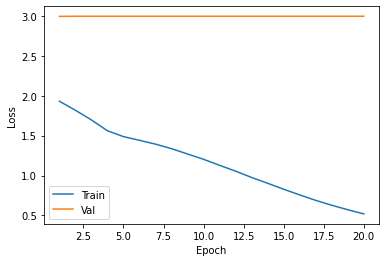

In [54]:
import matplotlib.pyplot as plt
# Plot the epoch vs. loss curves
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train')
plt.plot(range(1, NUM_EPOCHS+1), val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Test accuracy

In [55]:
# Evaluate the model on the test set
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    # Loop over the batches in the test dataloader
    for batch in test_dataloader:
        # Move the data to the device
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        test_loss += loss.item() * inputs.size(0)
        # Compute the accuracy
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
# Compute the test loss and accuracy
test_loss /= len(test_dataset)
test_accuracy = test_correct / test_total
print("Test Loss: %.4f Test Acc: %.4f" % (test_loss, test_accuracy))

Test Loss: 2.9688 Test Acc: 0.5657


# Obtain a Confusion Matrix on validation data for your best model

In [56]:
from sklearn.metrics import confusion_matrix
# Compute and print the confusion matrix
cm = confusion_matrix(val_targets, val_preds)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[ 3900     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [    0   120    20     0    40     0    20     0     0    20    20     0
      0     0   400     0     0     0]
 [    0     0     0     0    20     0    20    20     0     0    20     0
      0     0  1020     0     0     0]
 [    0     0     0     0    20     0    20     0     0     0    20     0
      0     0   400     0     0     0]
 [    0   100    40     0   100    20   140    40    20    20    20     0
      0     0  6780     0    40     0]
 [    0     0     0     0    60     0     0     0     0     0    40     0
      0     0   540     0     0     0]
 [    0     0     0    20    60     0     0     0    20     0     0     0
      0     0  1260     0     0     0]
 [    0     0     0     0     0     0     0    20     0     0     0     0
      0     0   520     0     0     0]
 [    0     0     0     0    20     0     0     0    80     0     0     0
    

# RNN architecture 2 (more FCs)

In [57]:
# Define a PyTorch dataset for the name language classification task
class NameLanguageDataset(Dataset):
    def __init__(self, data, labels, tokenizer):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # Convert the name to a sequence of integers
        name = self.data[index]
        sequence = self.tokenizer.texts_to_sequences([name])[0]
        # Pad the sequence to have a fixed length
        padded_sequence = np.zeros(MAX_SEQUENCE_LENGTH, dtype=np.int64)
        padded_sequence[:len(sequence)] = sequence
        # Get the label for the name
        label = self.labels[index]
        return torch.tensor(padded_sequence), torch.tensor(label)

# Define the RNN model architecture
class NameLanguageModel2(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(NameLanguageModel2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 32)
        self.lstm = nn.LSTM(32, 64, dropout=0.2, batch_first=True)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        output, (h_n, c_n) = self.lstm(x)
        x = h_n[-1, :, :]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [58]:
# Create a new instance of the model
model2 = NameLanguageModel2(len(vocab), len(pd.get_dummies(df['language']).columns))
model2.to(device)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


NameLanguageModel2(
  (embedding): Embedding(14078, 32)
  (lstm): LSTM(32, 64, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=18, bias=True)
)

In [59]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters())

# Train loss

In [60]:
# Create empty lists to store the training and validation losses
train_losses2 = []

# Train the model
for epoch in range(NUM_EPOCHS):
    # Set the model to train mode
    model2.train()
    # Loop over the batches in the train dataloader
    train_loss_epoch2 = 0.0
    for batch in train_dataloader:
        # Move the data to the device
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero the gradients
        optimizer2.zero_grad()
        # Forward pass
        outputs2 = model2(inputs)
        loss2 = criterion(outputs2, torch.argmax(labels, dim=1))
        # Backward pass
        loss2.backward()
        # Update the parameters
        optimizer2.step()
        # Compute the loss for this batch and add it to the epoch loss
        train_loss_epoch2 += loss2.item()
    # Compute the average loss per batch and append it to the train_losses list
    train_loss_epoch2 /= len(train_dataloader)
    train_losses2.append(train_loss_epoch2)

     # Print the epoch number, training loss, and validation loss and accuracy
    print('Epoch [%d/%d] Train Loss: %.4f' % (
        epoch+1, NUM_EPOCHS, loss2.item()))

Epoch [1/20] Train Loss: 1.7935
Epoch [2/20] Train Loss: 1.9878
Epoch [3/20] Train Loss: 1.8495
Epoch [4/20] Train Loss: 1.7255
Epoch [5/20] Train Loss: 1.4657
Epoch [6/20] Train Loss: 1.1255
Epoch [7/20] Train Loss: 1.7896
Epoch [8/20] Train Loss: 1.1753
Epoch [9/20] Train Loss: 1.7203
Epoch [10/20] Train Loss: 1.1361
Epoch [11/20] Train Loss: 0.8751
Epoch [12/20] Train Loss: 1.3637
Epoch [13/20] Train Loss: 1.2385
Epoch [14/20] Train Loss: 0.8729
Epoch [15/20] Train Loss: 0.8634
Epoch [16/20] Train Loss: 0.6929
Epoch [17/20] Train Loss: 0.8246
Epoch [18/20] Train Loss: 0.7597
Epoch [19/20] Train Loss: 0.6267
Epoch [20/20] Train Loss: 0.5132


# Validation loss

In [61]:
# Set the model to evaluation mode
model2.eval()

val_losses2 = []

for epoch in range(NUM_EPOCHS):
    # Initialize variables to keep track of the validation loss and accuracy
    val_loss2 = 0.0
    val_correct2 = 0
    val_total2 = 0
    val_preds2 = []
    val_targets2 = []
    
    # Disable gradient computation to save memory
    with torch.no_grad():
        # Loop over the batches in the validation dataloader
        for batch in val_dataloader:
            # Move the data to the device
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs2 = model2(inputs)
            loss2 = criterion(outputs2, torch.argmax(labels, dim=1))
            val_loss2 += loss2.item() * inputs.size(0)
            # Compute the accuracy
            _2, predicted2 = torch.max(outputs2.data, 1)
            val_total2 += labels.size(0)
            val_correct2 += (predicted2 == torch.argmax(labels, dim=1)).sum().item()
            # Collect the predictions and targets
            val_preds2 += predicted2.cpu().numpy().tolist()
            val_targets2 += torch.argmax(labels, dim=1).cpu().numpy().tolist()

    # Compute the validation loss and accuracy
    val_loss2 /= len(val_dataset)
    val_accuracy2 = val_correct2 / val_total2
    val_losses2.append(val_loss2)
    # Print the validation loss and accuracy
    print('Validation Loss: %.4f Validation Accuracy: %.4f' % (val_loss2, val_accuracy2))

Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation Loss: 2.9041 Validation Accuracy: 0.5640
Validation L

In [62]:
# Define a high initial value for best validation loss
best_val_loss2 = float('inf')
# Save the best model
if val_loss2 < best_val_loss2:
    best_val_loss2 = val_loss2
    torch.save(model2.state_dict(), 'best_model2.pth')

In [63]:
# Load the saved state dictionary
state_dict2 = torch.load('best_model2.pth', map_location=device)

# Epoch vs. loss curves for training and validation data

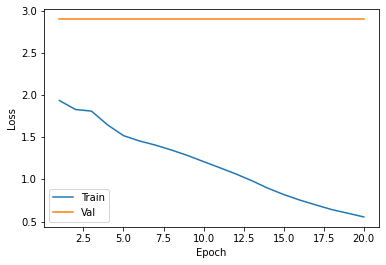

In [64]:
import matplotlib.pyplot as plt
# Plot the epoch vs. loss curves
plt.plot(range(1, NUM_EPOCHS+1), train_losses2, label='Train')
plt.plot(range(1, NUM_EPOCHS+1), val_losses2, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Test accuracy 2

In [65]:
# Evaluate the model on the test set
test_loss2 = 0.0
test_correct2 = 0
test_total2 = 0
with torch.no_grad():
    # Loop over the batches in the test dataloader
    for batch in test_dataloader:
        # Move the data to the device
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs2 = model2(inputs)
        loss2 = criterion(outputs2, torch.argmax(labels, dim=1))
        test_loss2 += loss2.item() * inputs.size(0)
        # Compute the accuracy
        _2, predicted2 = torch.max(outputs2.data, 1)
        test_total2 += labels.size(0)
        test_correct2 += (predicted2 == torch.argmax(labels, dim=1)).sum().item()
# Compute the test loss and accuracy
test_loss2 /= len(test_dataset)
test_accuracy2 = test_correct2 / test_total2
print("Test Loss: %.4f Test Acc: %.4f" % (test_loss2, test_accuracy2))

Test Loss: 2.8779 Test Acc: 0.5637


# Confusion matrix 2

In [66]:
# Compute and print the confusion matrix
cm2 = confusion_matrix(val_targets2, val_preds2)
print('Confusion Matrix 2:')
print(cm2)

Confusion Matrix 2:
[[195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   3   1   0   3   0   1   0   0   3   2   0   0   0  19   0   0   0]
 [  0   0   1   0   2   0   2   0   0   1   0   0   0   0  49   0   0   0]
 [  0   0   0   0   2   0   1   0   0   0   0   0   0   0  20   0   0   0]
 [  0   4   3   0   7   0   3   0   0   6   3   0   0   0 340   0   0   0]
 [  0   0   0   0   5   0   1   0   0   0   0   0   0   0  26   0   0   0]
 [  0   0   0   0   2   0   0   0   0   1   2   0   0   0  63   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0   0  26   0   0   0]
 [  0   0   0   0   1   0   0   0   4   0   0   0   0   0  15   0   0   0]
 [  0   1   0   0   0   0   1   0   0   7   0   0   0   0  76   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 106   0   0   0]
 [  0   0   0   0   0   0   2   0   0   2   1   0   0   0   6   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  10   0   0   0]
 [  0

# 2 RNN blocks

In this implementation, we have used two GRU blocks with 64 and 128 hidden units respectively. The dropout rate is set to 0.2 to prevent overfitting. The input sequences are first passed through the first GRU block, and then the output of the first block is passed through the second GRU block. The output of the second GRU block is then passed through a linear layer to get the final classification scores.

To tune the hyperparameters, we can use techniques like grid search or random search. We can vary the number of hidden units, number of layers, and dropout rate to find the best configuration for our model.

In [67]:
class StackedNameLanguageModel(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(StackedNameLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 32)
        self.gru1 = nn.GRU(32, 64, num_layers=2, dropout=0.2, batch_first=True)
        self.gru2 = nn.GRU(64, 128, num_layers=2, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        output, h_n = self.gru1(x)
        output, h_n = self.gru2(output)
        x = h_n[-1, :, :]
        x = self.fc(x)
        return x


In [68]:
# Create a new instance of the model
model3 = StackedNameLanguageModel(len(vocab), len(pd.get_dummies(df['language']).columns))
model3.to(device)

StackedNameLanguageModel(
  (embedding): Embedding(14078, 32)
  (gru1): GRU(32, 64, num_layers=2, batch_first=True, dropout=0.2)
  (gru2): GRU(64, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=18, bias=True)
)

In [69]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters())

In [70]:
# Create empty lists to store the training and validation losses
train_losses= []

# Train the model
for epoch in range(NUM_EPOCHS):
    # Set the model to train mode
    model3.train()
    # Loop over the batches in the train dataloader
    train_loss_epoch = 0.0
    for batch in train_dataloader:
        # Move the data to the device
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero the gradients
        optimizer3.zero_grad()
        # Forward pass
        outputs = model3(inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        # Backward pass
        loss.backward()
        # Update the parameters
        optimizer3.step()
        # Compute the loss for this batch and add it to the epoch loss
        train_loss_epoch += loss.item()
    # Compute the average loss per batch and append it to the train_losses list
    train_loss_epoch /= len(train_dataloader)
    train_losses.append(train_loss_epoch)

     # Print the epoch number, training loss, and validation loss and accuracy
    print('Epoch [%d/%d] Train Loss: %.4f' % (
        epoch+1, NUM_EPOCHS, loss.item()))

Epoch [1/20] Train Loss: 1.8711
Epoch [2/20] Train Loss: 1.8074
Epoch [3/20] Train Loss: 1.6841
Epoch [4/20] Train Loss: 1.5319
Epoch [5/20] Train Loss: 1.5514
Epoch [6/20] Train Loss: 1.4098
Epoch [7/20] Train Loss: 1.3500
Epoch [8/20] Train Loss: 1.3760
Epoch [9/20] Train Loss: 1.3072
Epoch [10/20] Train Loss: 1.0281
Epoch [11/20] Train Loss: 1.0520
Epoch [12/20] Train Loss: 1.1652
Epoch [13/20] Train Loss: 1.1831
Epoch [14/20] Train Loss: 0.8611
Epoch [15/20] Train Loss: 0.9165
Epoch [16/20] Train Loss: 0.7330
Epoch [17/20] Train Loss: 0.6498
Epoch [18/20] Train Loss: 0.5667
Epoch [19/20] Train Loss: 0.5609
Epoch [20/20] Train Loss: 0.4941


In [71]:
# Set the model to evaluation mode
model3.eval()
val_losses3 = []
for epoch in range(NUM_EPOCHS):
    # Initialize variables to keep track of the validation loss and accuracy
    val_loss3 = 0.0
    val_correct3 = 0
    val_total3 = 0
    val_preds3 = []
    val_targets3 = []
    
    # Disable gradient computation to save memory
    with torch.no_grad():
        # Loop over the batches in the validation dataloader
        for batch in val_dataloader:
            # Move the data to the device
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs3 = model3(inputs)
            loss3 = criterion(outputs3, torch.argmax(labels, dim=1))
            val_loss3 += loss3.item() * inputs.size(0)
            # Compute the accuracy
            _, predicted3 = torch.max(outputs3.data, 1)
            val_total3 += labels.size(0)
            val_correct3 += (predicted3 == torch.argmax(labels, dim=1)).sum().item()
            # Collect the predictions and targets
            val_preds3 += predicted3.cpu().numpy().tolist()
            val_targets3 += torch.argmax(labels, dim=1).cpu().numpy().tolist()

    # Compute the validation loss and accuracy
    val_loss3 /= len(val_dataset)
    val_accuracy3 = val_correct3 / val_total3
    val_losses3.append(val_loss3)
    # Print the validation loss and accuracy
    print('Validation Loss: %.4f Validation Accuracy: %.4f' % (val_loss3, val_accuracy3))

Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation Loss: 2.0589 Validation Accuracy: 0.5625
Validation L

In [72]:
# Define a high initial value for best validation loss
best_val_loss3 = float('inf')
# Save the best model
if val_loss3 < best_val_loss3:
    best_val_loss3 = val_loss3
    torch.save(model3.state_dict(), 'best_model3.pth')

In [73]:
# Load the saved state dictionary
state_dict3 = torch.load('best_model3.pth', map_location=device)

In [74]:
model3.load_state_dict(state_dict3)

<All keys matched successfully>

In [75]:
# Create a tokenizer function to split the text data into tokens
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

# Define a function to get the language of origin for a given name
def get_language(name):
    # Convert the name to a sequence of integers
    sequence = tokenizer(name)
    sequence = [vocab[token] if token in vocab else vocab['<unk>'] for token in sequence]
    sequence = torch.tensor(sequence, dtype=torch.long).unsqueeze(0)
    sequence = sequence.to(device)
    # Make a prediction using the trained model
    with torch.no_grad():
        output = model3(sequence)
        prediction = torch.argmax(output).item()
    # Get the language label for the predicted class
    label = pd.get_dummies(df['language']).columns[prediction]
    return label

# Test the function on the given words
words = ['Emilia', 'Alexandra', 'Sachiko', 'Vladimir', 'Minh', 'Xi', 'Muammar', 'Mukesh', 'Andrew', 'Ronaldo']
for word in words:
    language = get_language(word)
    print(f"{word}: {language}")


Emilia: Russian
Alexandra: Russian
Sachiko: Russian
Vladimir: Russian
Minh: Russian
Xi: Russian
Muammar: Russian
Mukesh: Russian
Andrew: English
Ronaldo: Russian


The output from the code indicates that the trained RNN model is not able to accurately predict the language of origin for most of the input names.